In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
import tellurium as te
import os
import pickle
import seaborn as sns

In [3]:
# Set Matplotlib rcParams to configure line widths globally
mpl.rcParams['lines.linewidth'] = 2  # Line width for all lines
mpl.rcParams['axes.linewidth'] = 2   # Line width of axes
mpl.rcParams['xtick.major.width'] = 2  # Line width of major x-ticks
mpl.rcParams['xtick.minor.width'] = 2  # Line width of minor x-ticks
mpl.rcParams['ytick.major.width'] = 2  # Line width of major y-ticks
mpl.rcParams['ytick.minor.width'] = 2  # Line width of minor y-ticks

In [4]:

def load_file(file_loc: str):
    '''
    Function to load file either json or pickled .txt
    ---------------------------------------------------
    Parameter:
    file_loc: str path to file
    ---------------------------------------------------
    returns:
    data: either unpickled tuple or list 
    '''
    if file_loc.endswith('.txt'):
            with open(file_loc, 'rb') as g:
                # data = tuple with [0]=score, [1]=parameter_dict
                data = pickle.loads(g.read())
    else:
        with open(file_loc, 'r') as g:
            # data = list with [0]=score, [1]=parameter_dict
            data = json.loads(g.read())

    return data

def get_parameter_sets(d_path, dir):
    '''
    Description: function to find the best scoring parameter set for specified model
    -----------
    Parameter:
    d_path: pathway to directory with parameter sets
    n_sets: number of best sets 
    ----------
    returns:
    dresults: pd.DataFrame() with best score as name and parameter names as index
    '''
    d_path = d_path+f'/{dir}'
    files = os.listdir(d_path)
    files = [file for file in files if '.json' in file]
    
    dresults = pd.DataFrame()
    for file in files:
        filename = file
        path = d_path+'/'
        
        data = load_file(path+filename)
        #print(data["update_parameters"])
        # add score to dict for later use
        #data[1]['score'] = data[0]
        dnew = pd.DataFrame.from_dict(data["update_parameters"], orient='index',columns=['Value'])
        # dataframe with each colume parameter set of estimation and name = score 
        dresults[str(data["best_score"])] = dnew['Value']
    # sort the colums names to find lowest estimation score   
    results = sorted(list(map(float, dresults.columns.to_list())))
    results = np.asarray(results,dtype=str)
        
    return dresults

In [11]:
path = '../Estimation/'
dir_locs = ['general', 
            'Hapto', 
            'immune']
pth_ar = []
for i,dir in enumerate(dir_locs):
    pth_ar.append(get_parameter_sets(path+dir, 'pth'))

In [12]:
pth_ar[1].T.describe()

,E,R,P,k_P_birth,LDH_RBC,k_E_infect,tropism,M,a_P_d,k_P_d,...,k_iE_pit_frac,t_E_death,s_BH,LDH,k_M_death,t_halb_HP_decay,t_halb_HCC_decay,par1_fHb,par2_fHb,switch_fHb
count,1.000000e+01,10.000000,10.000000,10.000000,1.000000e+01,1.000000e+01,10.000000,10.000000,1.000000e+01,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.433395e+06,153284.285494,1476.156951,1185.684993,4.059699e-10,1.769123e-06,14.563040,2554.576552,1.208708e+06,7.265608,...,0.296042,102.356306,0.000015,245.336157,70.737269,4.810619,0.005615,4545.311704,0.000604,6138.914354
std,2.583716e+05,206697.286563,1957.047638,2041.786621,1.463068e-10,6.957291e-07,9.155954,2577.738069,3.154385e+06,4.453532,...,0.303207,7.451289,0.000030,46.853138,34.920278,0.934672,0.002364,745.858355,0.000645,1335.566840
min,4.698713e+06,64312.817109,550.688967,156.345073,3.047148e-11,9.641044e-07,2.061683,100.000000,2.024901e+03,0.001000,...,0.032198,100.000000,0.000001,140.000000,30.000000,3.637911,0.003081,4000.000000,0.000400,4031.135633
25%,5.508764e+06,87512.818202,718.184355,566.595178,3.917996e-10,1.188589e-06,5.607567,100.087715,2.025526e+03,4.409677,...,0.032202,100.000000,0.000002,239.406745,30.181934,3.918321,0.003575,4000.000000,0.000400,5449.581864
50%,5.508765e+06,92987.659442,1006.051919,603.290189,3.918093e-10,1.820254e-06,19.301030,2572.707824,3.043824e+03,9.998894,...,0.134651,100.000000,0.000007,259.862274,96.245394,4.828423,0.004921,4000.000066,0.000400,6022.846628
75%,5.515609e+06,92988.615037,1006.331299,603.448651,5.092247e-10,1.857491e-06,19.303309,5000.000000,1.647325e+04,9.999945,...,0.631287,100.000000,0.000009,280.000000,97.912703,5.725443,0.007785,5160.291801,0.000400,7197.169311
max,5.544609e+06,741029.939552,7024.742796,6983.579128,5.427112e-10,3.164285e-06,30.227889,5000.000000,9.999943e+06,9.999980,...,0.668793,123.563048,0.000100,280.000000,99.200206,5.946460,0.008975,5998.899313,0.002441,7999.999825


Index(['fac_R_d', 'LDH_RBC', 'k_E_infect', 's_BH', 'k_iE_pit_frac', 'r_P_d',
       'slope_rpi', 'k_P_art_max', 'tropism', 'k_P_d', 't_mat_P', 'k_M_death',
       't_E_death', 'LDH', 'k_P_birth', 'P', 'M', 'a_P_d', 'R', 'E'],
      dtype='object')


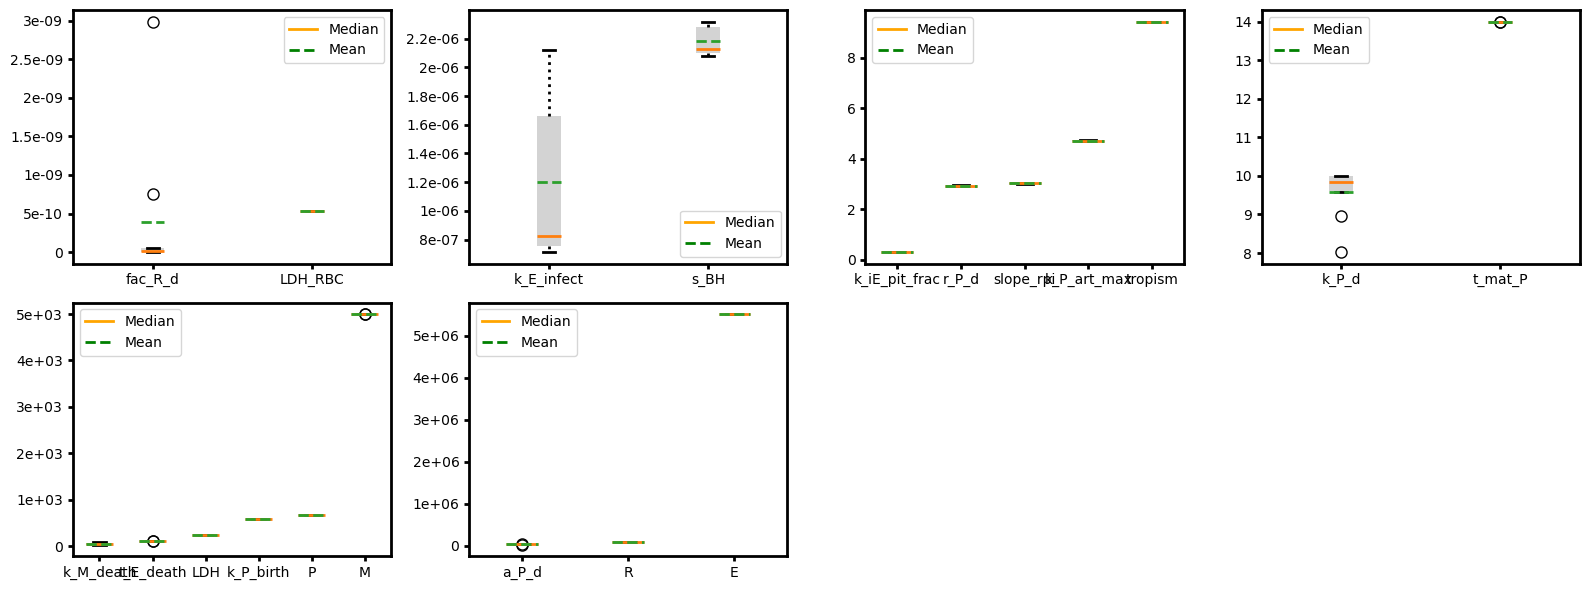

Index(['LDH_RBC', 'k_E_infect', 's_BH', 'par2_fHb', 't_halb_HCC_decay',
       'k_iE_pit_frac', 'fac_R_d', 'k_P_art_max', 'r_P_d', 't_halb_HP_decay',
       'k_P_d', 't_mat_P', 'slope_rpi', 'tropism', 'k_M_death', 't_E_death',
       'LDH', 'k_P_birth', 'P', 'M', 'par1_fHb', 'switch_fHb', 'R', 'a_P_d',
       'E'],
      dtype='object')


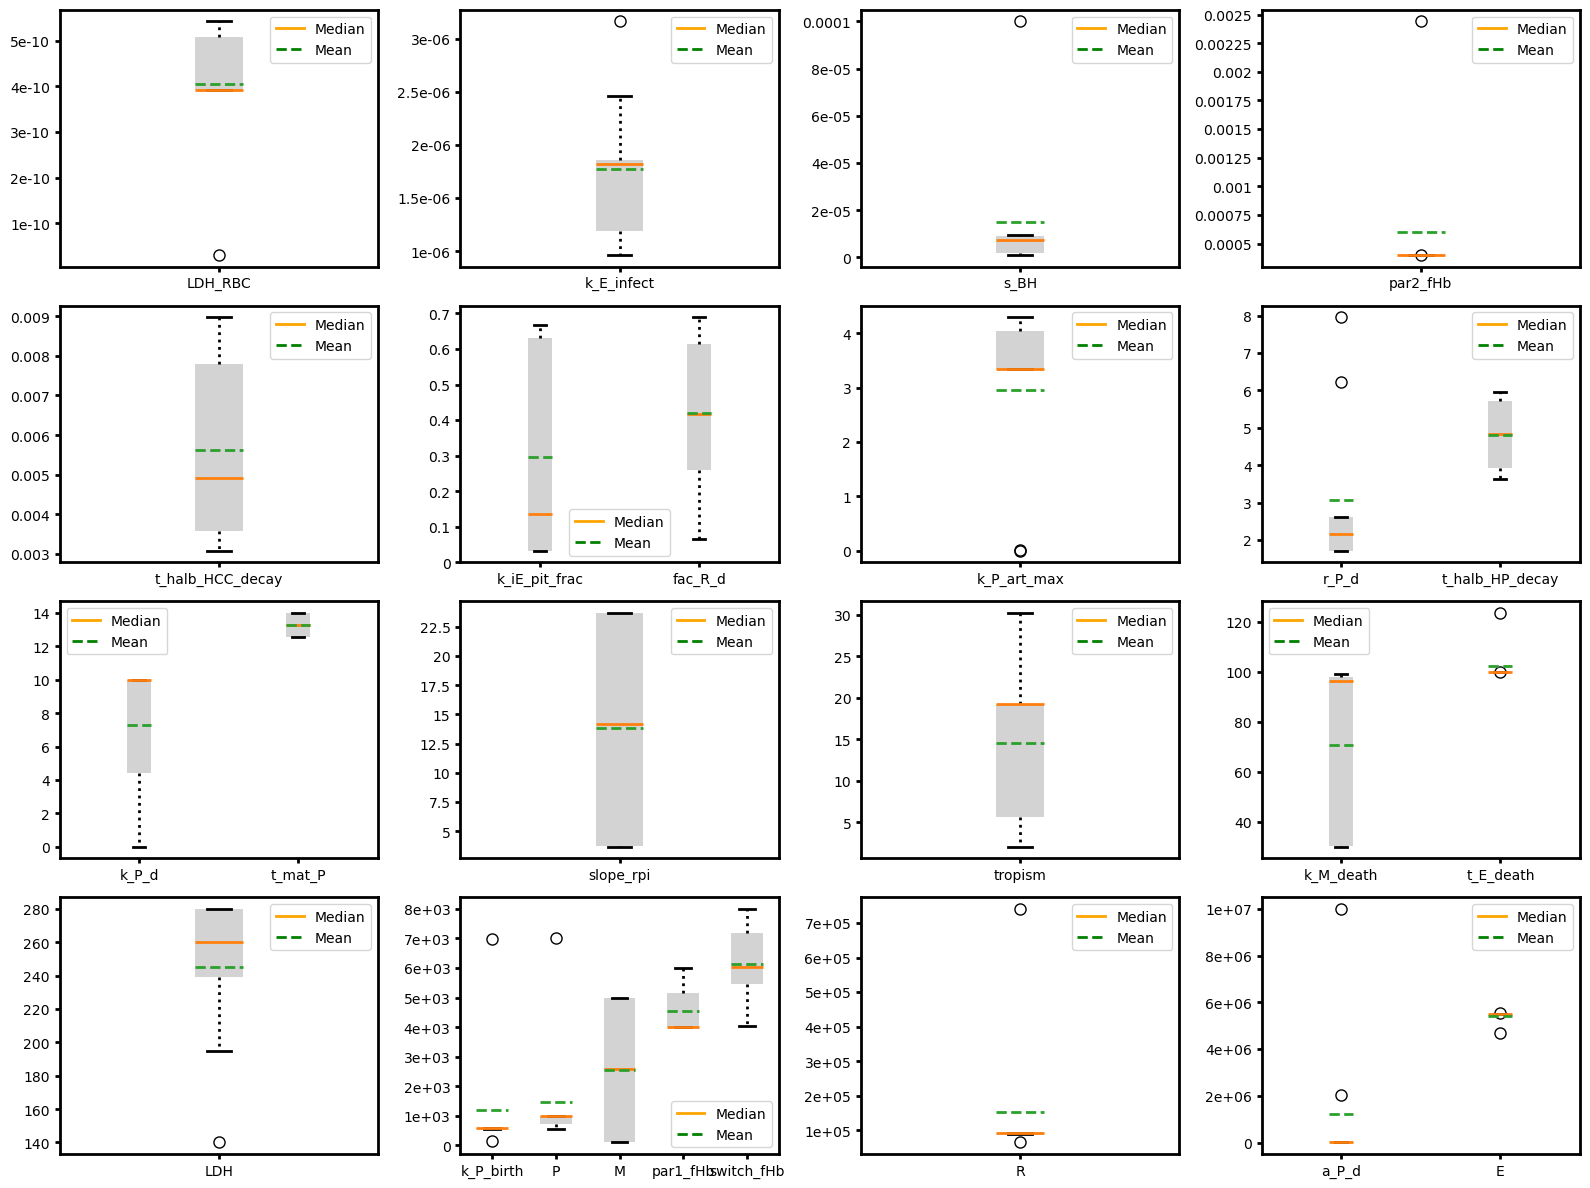

Index(['LDH_RBC', 'k_E_infect', 'k_digest_R', 'mu_tox', 'k_digest_E',
       'k_digest_M', 'delta_Ttox', 'Ttox', 'k_iE_pit_frac', 'beta_Treg',
       'fac_R_d', 'epsilon', 'mu_in_tox', 'k_digest_oiE', 'r_P_d',
       'delta_Treg', 'k_digest_iE', 'k_P_art_max', 'tropism', 'k_P_d',
       't_mat_P', 'slope_rpi', 'beta_in_Treg', 'V_f', 'k_M_death', 'K_f',
       't_E_death', 'LDH', 'M', 'k_P_birth', 'P', 'a_P_d', 'R', 'Treg', 'E'],
      dtype='object')


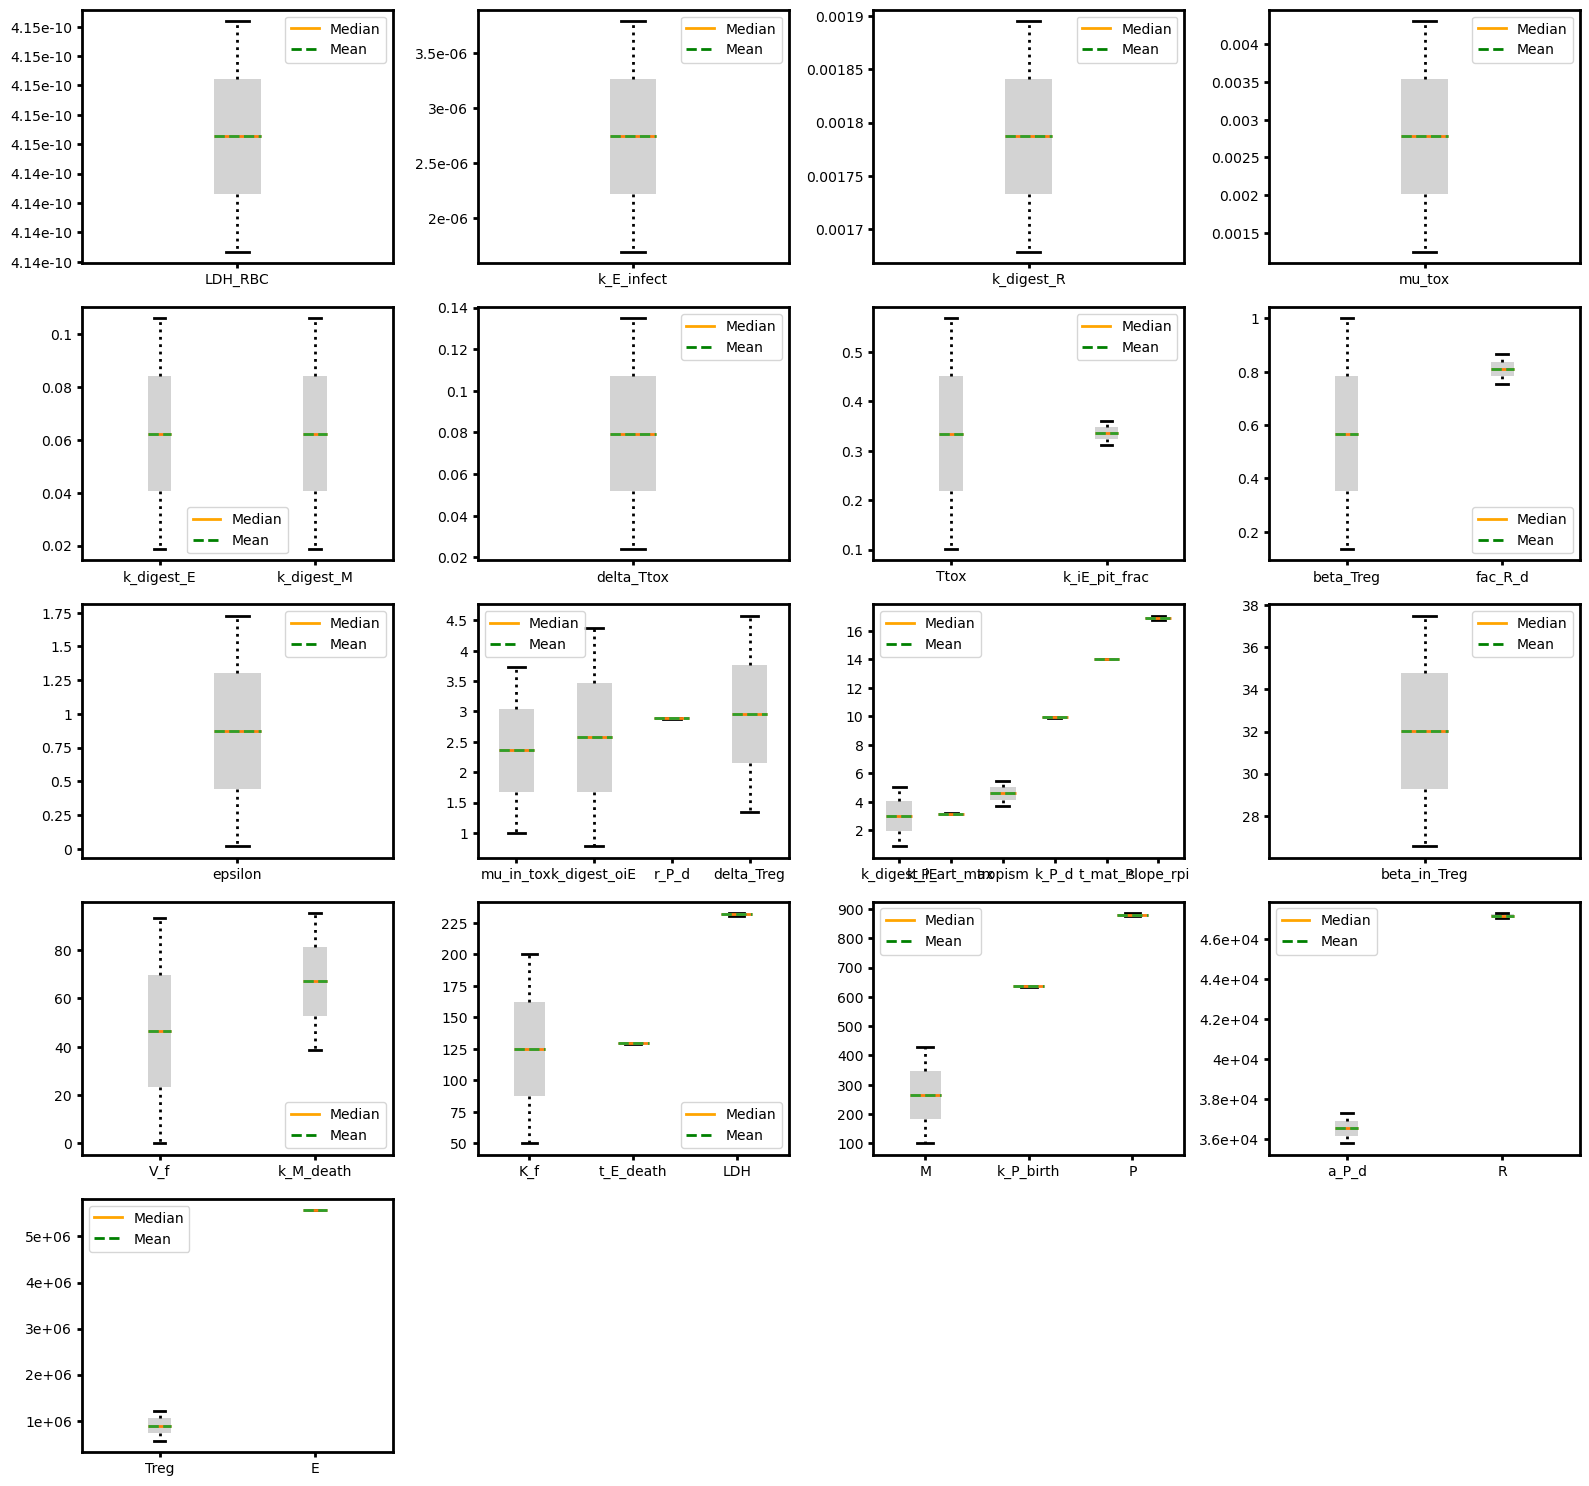

In [14]:
# Function to categorize columns based on data range
def categorize_columns(df):
    column_means = df.mean()
    sorted_columns = column_means.sort_values().index
    print(sorted_columns)
    column_groups = []
    current_group = []
    current_max = df[sorted_columns[0]].max()
    
    for col in sorted_columns:
        if (df[col].max() - df[col].min()) > current_max:
            column_groups.append(current_group)
            current_group = [col]
            current_max = df[col].max()
        else:
            current_group.append(col)
    
    if current_group:
        column_groups.append(current_group)
    
    return column_groups
for dfp in pth_ar: 
    df = dfp.T
    # Get column groups based on data ranges
    column_groups = categorize_columns(df)

    # Plotting boxplots in subplots
    n_cols = 4
    n_rows = int(np.ceil(len(column_groups)/n_cols))  

    fig, axes = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*4, n_rows*3))

    meanlineprops = dict(linewidth=2)
    for i, columns in enumerate(column_groups):
        df_boxplot = df[columns]
        bp = df_boxplot.boxplot(ax=axes.flatten()[i], vert=True, 
                        showmeans=True, meanline=True, showfliers=True, patch_artist=True,#notch=True,
                        boxprops=dict(linewidth=0, facecolor='lightgrey'), medianprops=dict(linewidth=2),
                        whiskerprops=dict(ls='dotted', linewidth=2), capprops=dict(linewidth=2),
                        flierprops=dict(markersize=8), meanprops=meanlineprops)
        
        axes.flatten()[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.3g}'))
        axes.flatten()[i].grid(False)
        # Add mean and median to legend
        handles, labels = axes.flatten()[i].get_legend_handles_labels()
        median_handle = plt.Line2D([0], [0], color='orange', linewidth=2, label='Median')
        mean_handle = plt.Line2D([0], [0], ls='--', color='green', linewidth=2, label='Mean')
        handles.extend([median_handle, mean_handle])
        axes.flatten()[i].legend(handles=handles,)

    for axs in axes.flatten():
        if not axs.lines: 
            axs.set_visible(False)

    plt.tight_layout()
    plt.show()

Index(['fac_R_d', 'LDH_RBC', 'k_E_infect', 's_BH', 'k_iE_pit_frac', 'r_P_d',
       'slope_rpi', 'k_P_art_max', 'tropism', 'k_P_d', 't_mat_P', 'k_M_death',
       't_E_death', 'LDH', 'k_P_birth', 'P', 'M', 'a_P_d', 'R', 'E'],
      dtype='object')


/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

10.0% of the points cannot

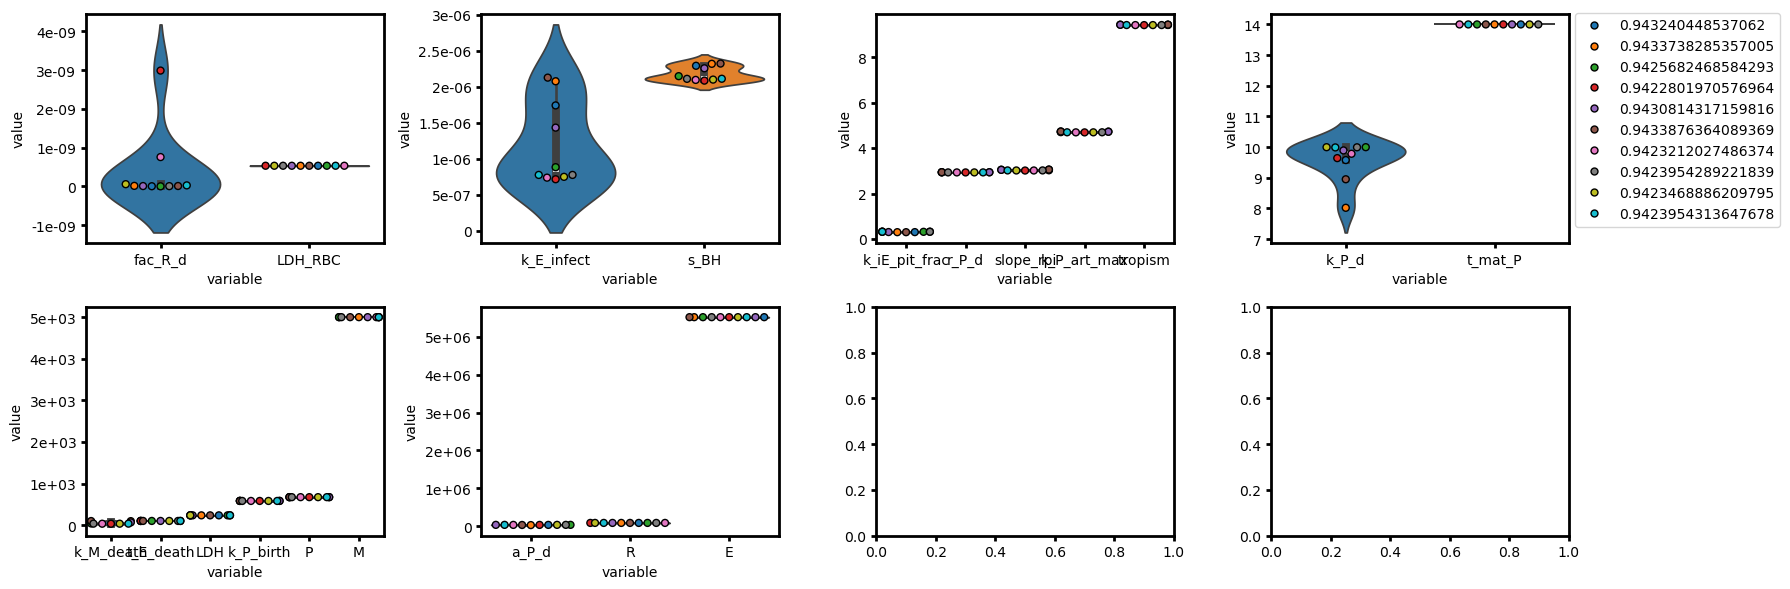

Index(['LDH_RBC', 'k_E_infect', 's_BH', 'par2_fHb', 't_halb_HCC_decay',
       'k_iE_pit_frac', 'fac_R_d', 'k_P_art_max', 'r_P_d', 't_halb_HP_decay',
       'k_P_d', 't_mat_P', 'slope_rpi', 'tropism', 'k_M_death', 't_E_death',
       'LDH', 'k_P_birth', 'P', 'M', 'par1_fHb', 'switch_fHb', 'R', 'a_P_d',
       'E'],
      dtype='object')


/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/lib/python3/dist-packages/seaborn/categorical.py:3399: UserWarning:

10.0% of the points cannot

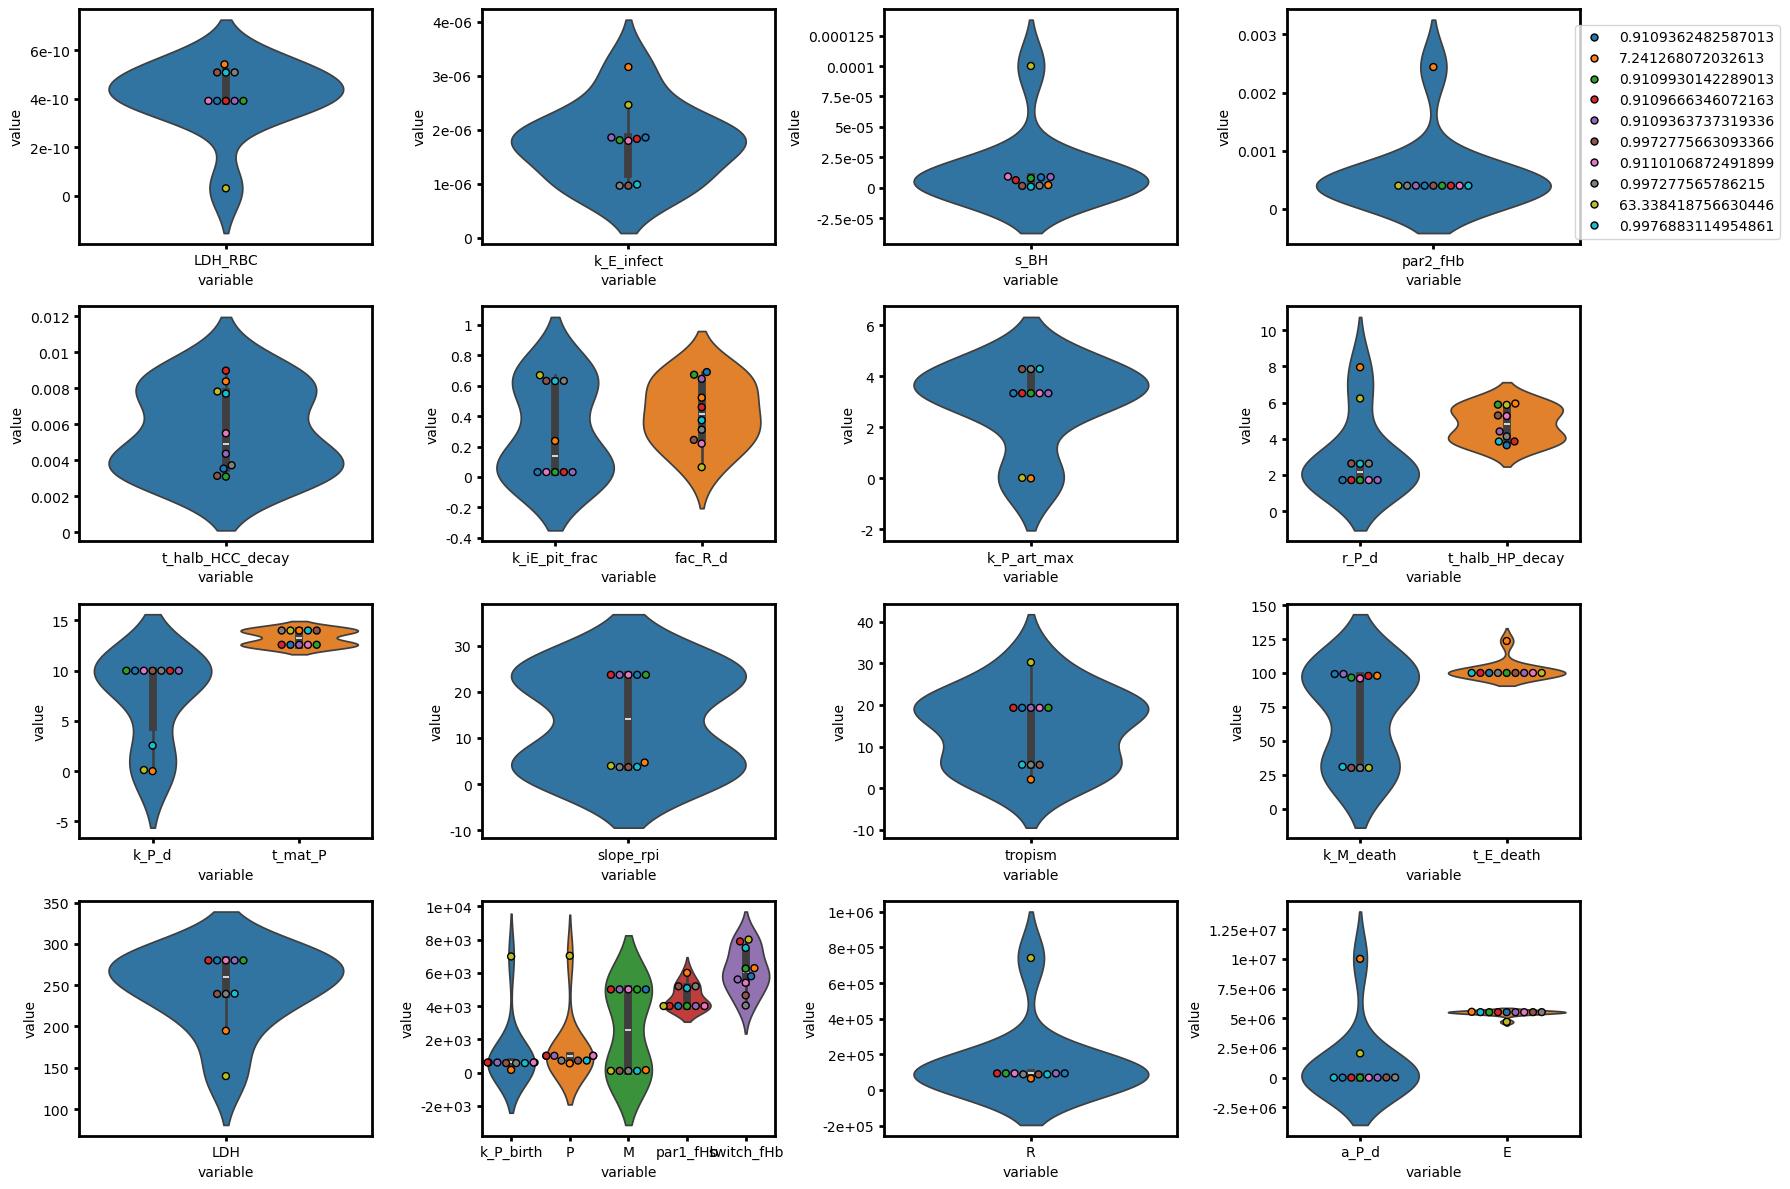

Index(['LDH_RBC', 'k_E_infect', 'k_digest_R', 'mu_tox', 'k_digest_E',
       'k_digest_M', 'delta_Ttox', 'Ttox', 'k_iE_pit_frac', 'beta_Treg',
       'fac_R_d', 'epsilon', 'mu_in_tox', 'k_digest_oiE', 'r_P_d',
       'delta_Treg', 'k_digest_iE', 'k_P_art_max', 'tropism', 'k_P_d',
       't_mat_P', 'slope_rpi', 'beta_in_Treg', 'V_f', 'k_M_death', 'K_f',
       't_E_death', 'LDH', 'M', 'k_P_birth', 'P', 'a_P_d', 'R', 'Treg', 'E'],
      dtype='object')


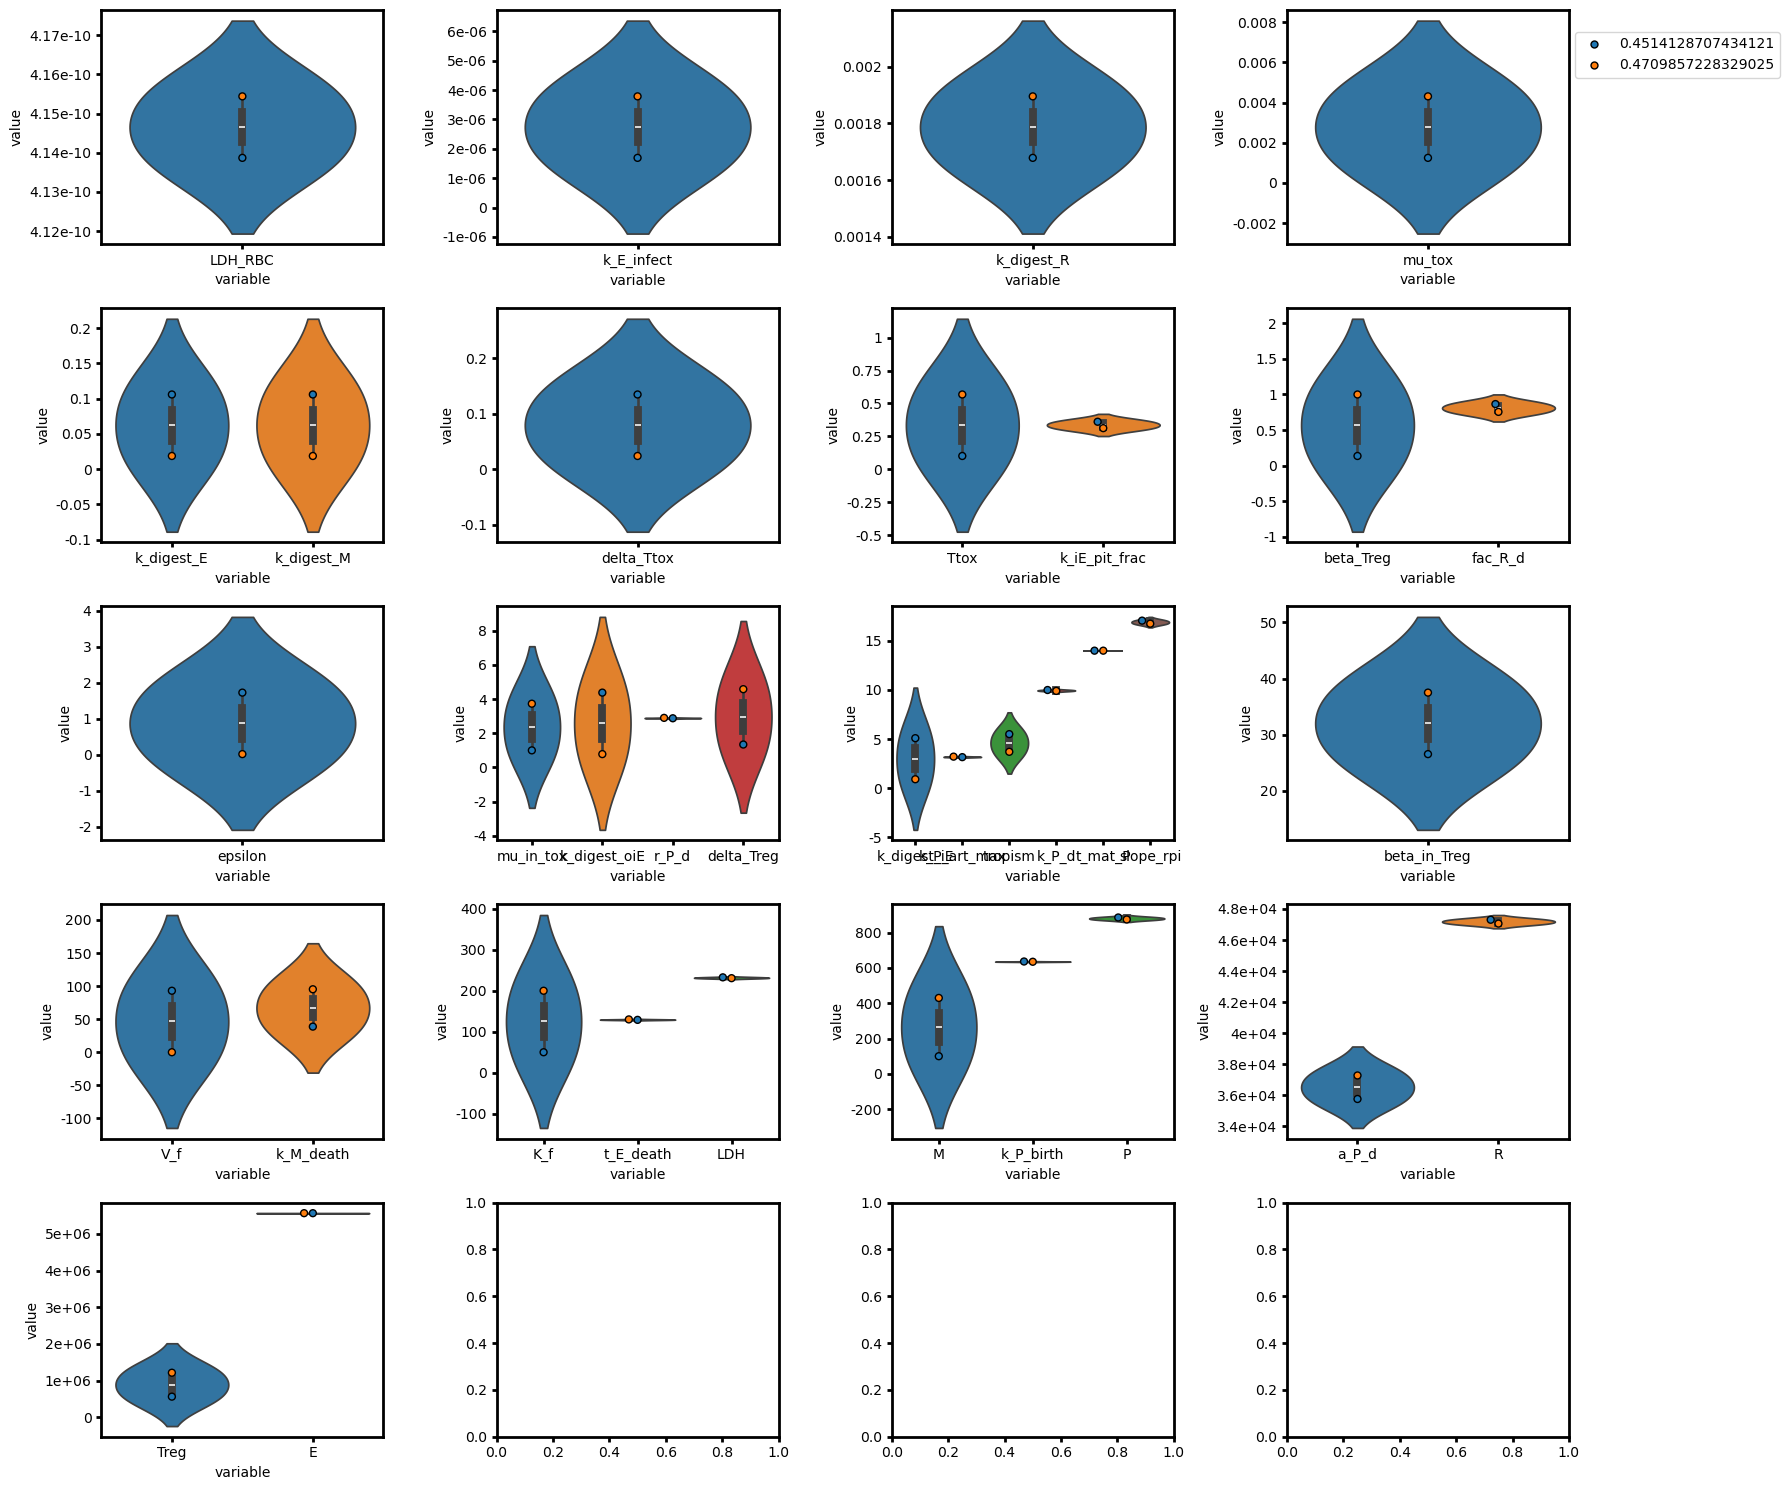

In [171]:
for dfp in pth_ar:
    df = dfp.T
    # Get column groups based on data ranges
    column_groups = categorize_columns(df)

    # Plotting boxplots in subplots
    n_cols = 4
    n_rows = int(np.ceil(len(column_groups)/n_cols))  

    fig, axes = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*4, n_rows*3))
    # Custom colors for boxplot elements

    for i, columns in enumerate(column_groups):
        df_boxplot = df[columns].copy()  # Make a copy of the subset DataFrame
        df_boxplot['num']=df_boxplot.index
        melted_df = pd.melt(df_boxplot, id_vars='num',value_vars=df_boxplot.columns)  # Update value_vars with your column names
        
        ax = axes.flatten()[i]

        # Plot violin plot
        sns.violinplot(data=df_boxplot, ax=ax,)
        # Plot swarm plot with hue based on numeric index
        swarm = sns.swarmplot(data=melted_df, ax=ax, x='variable',y='value', hue='num', edgecolor='black', linewidth=1,)
        if i==0:
            # Collect handles and labels for legend
            handles, labels = swarm.get_legend_handles_labels()
            ax.get_legend().remove()
        else:
            ax.get_legend().remove()
        # Format y-axis labels
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.3g}'))

        # Turn off grid lines
        ax.grid(False)

    plt.tight_layout()
    fig.legend(handles=handles, labels=labels, loc='upper right', bbox_to_anchor=(1.12, 0.98))
    plt.show()